File to run the ED calculation in a subsequent step. Use a number of images as input samples. This Program returns their nearest neighbors based on ED.

In [1]:
import torch
from torchvision import transforms

import glob
import numpy as np

import csv


from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline

from tqdm.notebook import tqdm      #progress bar

C:\Users\sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\sk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
path_input = '../data/input/256x256/offset_x4'
path_output='.'
name_output='DCGAN_256x256'
format_input = '.jpg'
path_input_samples = './generated'
format_input_samples = '.jpg'

In [3]:
def to_csv(name, array):
    with open(name, 'w') as file:
        # using csv.writer method from CSV package
        write = csv.writer(file)
        
        write.writerow(array)

In [4]:
# Create a list of transfomations
transforms1 = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

#transforms = transforms.Compose([transforms.Resize(resize_input), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # resize operation is outsourced
print('Applying the following transformations:\n\n' + str(transforms))

Applying the following transformations:

<module 'torchvision.transforms' from 'C:\\Users\\sk\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\torchvision\\transforms\\__init__.py'>


In [5]:
train_set = []

for file in (pbar := tqdm(glob.glob(path_input + '/*' + format_input))):                   # Get training data from specified folder
    pbar.set_description('Loading images from directory')
    img = Image.open(file)                      # Use PIL to load images
    img_tensor = transforms1(img)                # Apply the transformations defined above, 'torch.Size([1, size_input, size_input])' with only one color channel (gray image)
    train_set.append(img_tensor)       # Append tupel ( , )
    
# Shorter but less customizable method:
#dataset = datasets.ImageFolder('../2DGAN_Data/input_256x256_debug', transform=transforms)  
# The images are labeled with the class taken from the directory name (more suited for input data with different labels) 

  0%|          | 0/29280 [00:00<?, ?it/s]

In [6]:
# Create a list of transfomations
transforms2 = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.Grayscale()]
)

#transforms = transforms.Compose([transforms.Resize(resize_input), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # resize operation is outsourced
print('Applying the following transformations:\n\n' + str(transforms))

Applying the following transformations:

<module 'torchvision.transforms' from 'C:\\Users\\sk\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\torchvision\\transforms\\__init__.py'>


In [7]:
generated_samples = []
#random.shuffle(train_list) # not necessary, DataLoader shuffles both the batches and the input images

for file in (pbar := tqdm(glob.glob(path_input_samples + '/*' + '.png'))):                   # Get training data from specified folder
    pbar.set_description('Loading images from directory')
    img = Image.open(file)                      # Use PIL to load images
    img_tensor = transforms2(img)                # Apply the transformations defined above, 'torch.Size([1, size_input, size_input])' with only one color channel (gray image)
    generated_samples.append(img_tensor)       # Append tupel ( , )
    
# Shorter but less customizable method:
#dataset = datasets.ImageFolder('../2DGAN_Data/input_256x256_debug', transform=transforms)  
# The images are labeled with the class taken from the directory name (more suited for input data with different labels) 
print(generated_samples[0].shape)

  0%|          | 0/7 [00:00<?, ?it/s]

torch.Size([1, 256, 256])


[array([ 743, 1583], dtype=int64), array([4028, 4123], dtype=int64), array([4125, 4030], dtype=int64), array([4658, 3994], dtype=int64), array([3341, 3438], dtype=int64), array([23584, 23479], dtype=int64)]
---


  0%|          | 0/75 [00:00<?, ?it/s]

IndexError: list index out of range

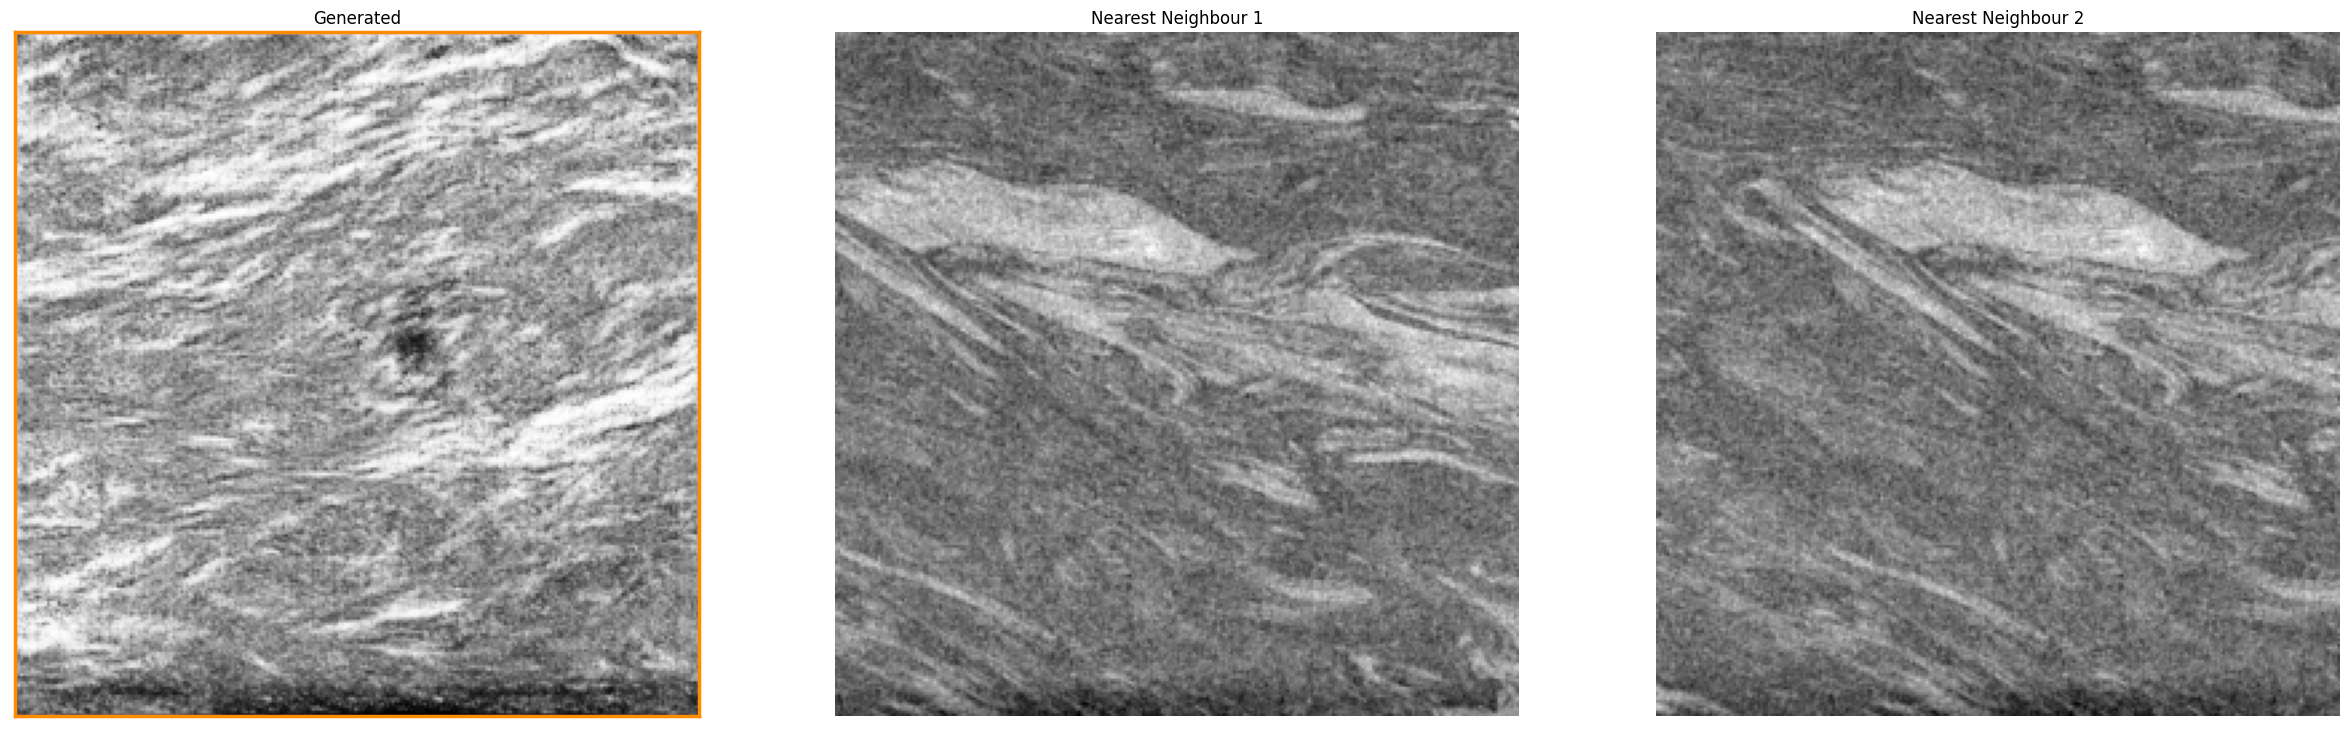

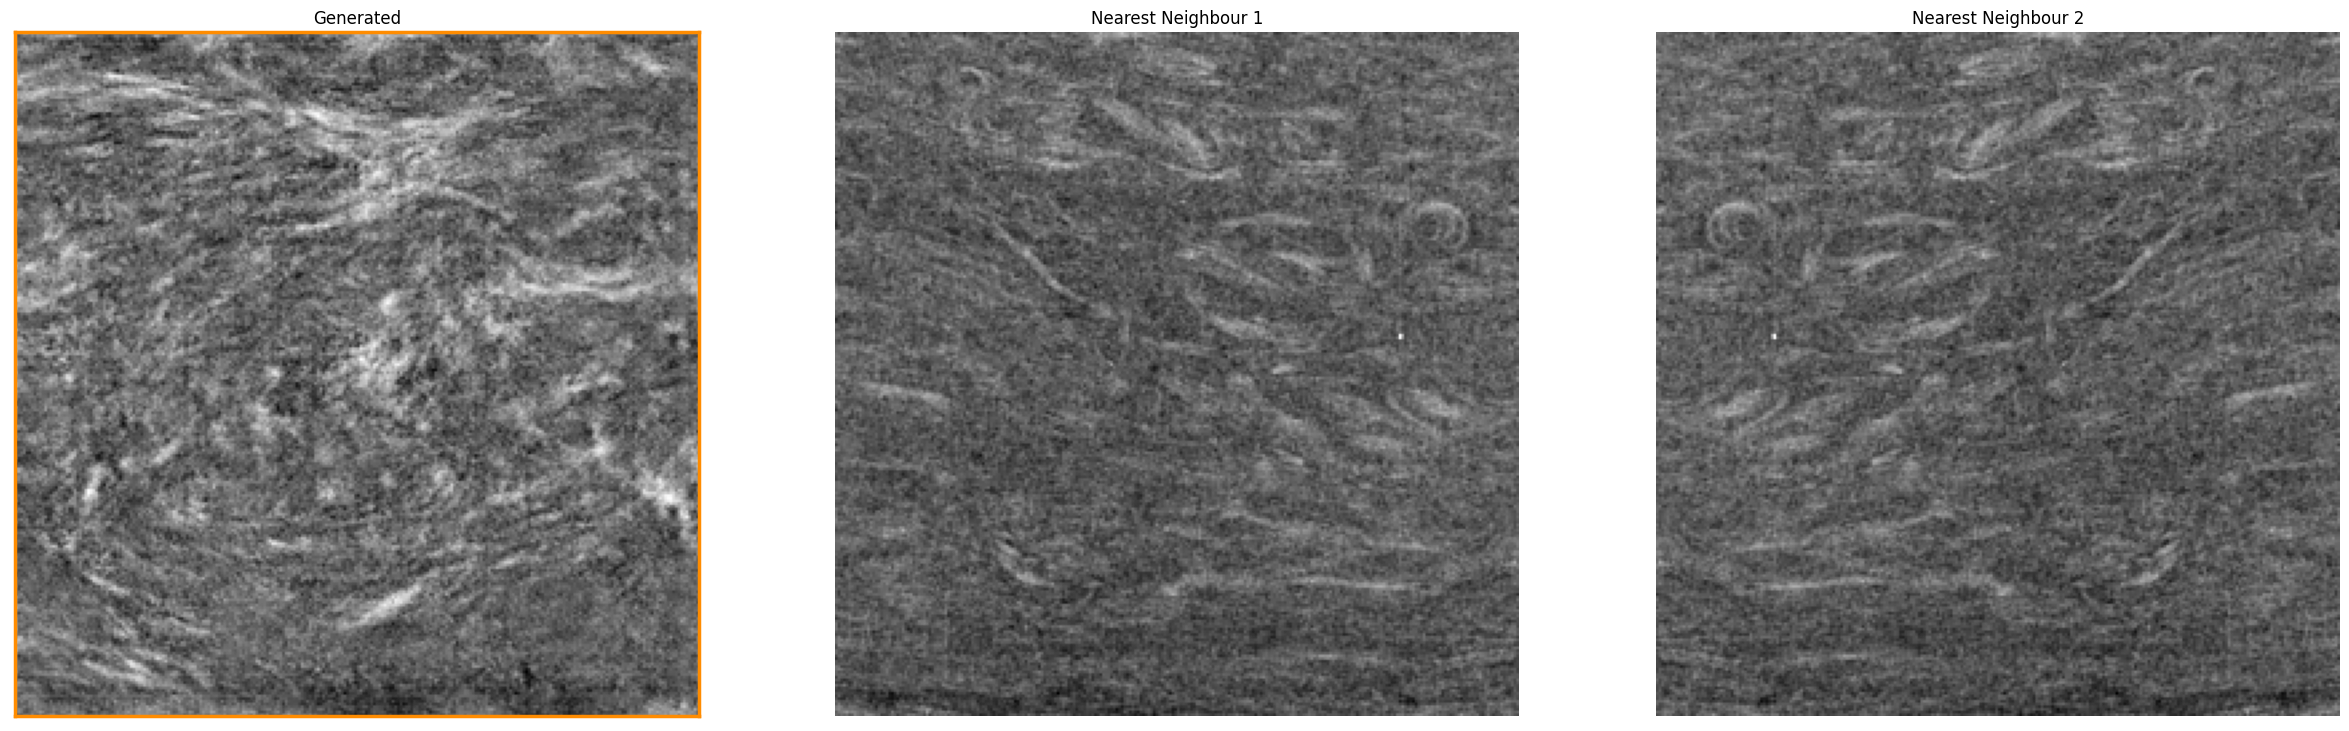

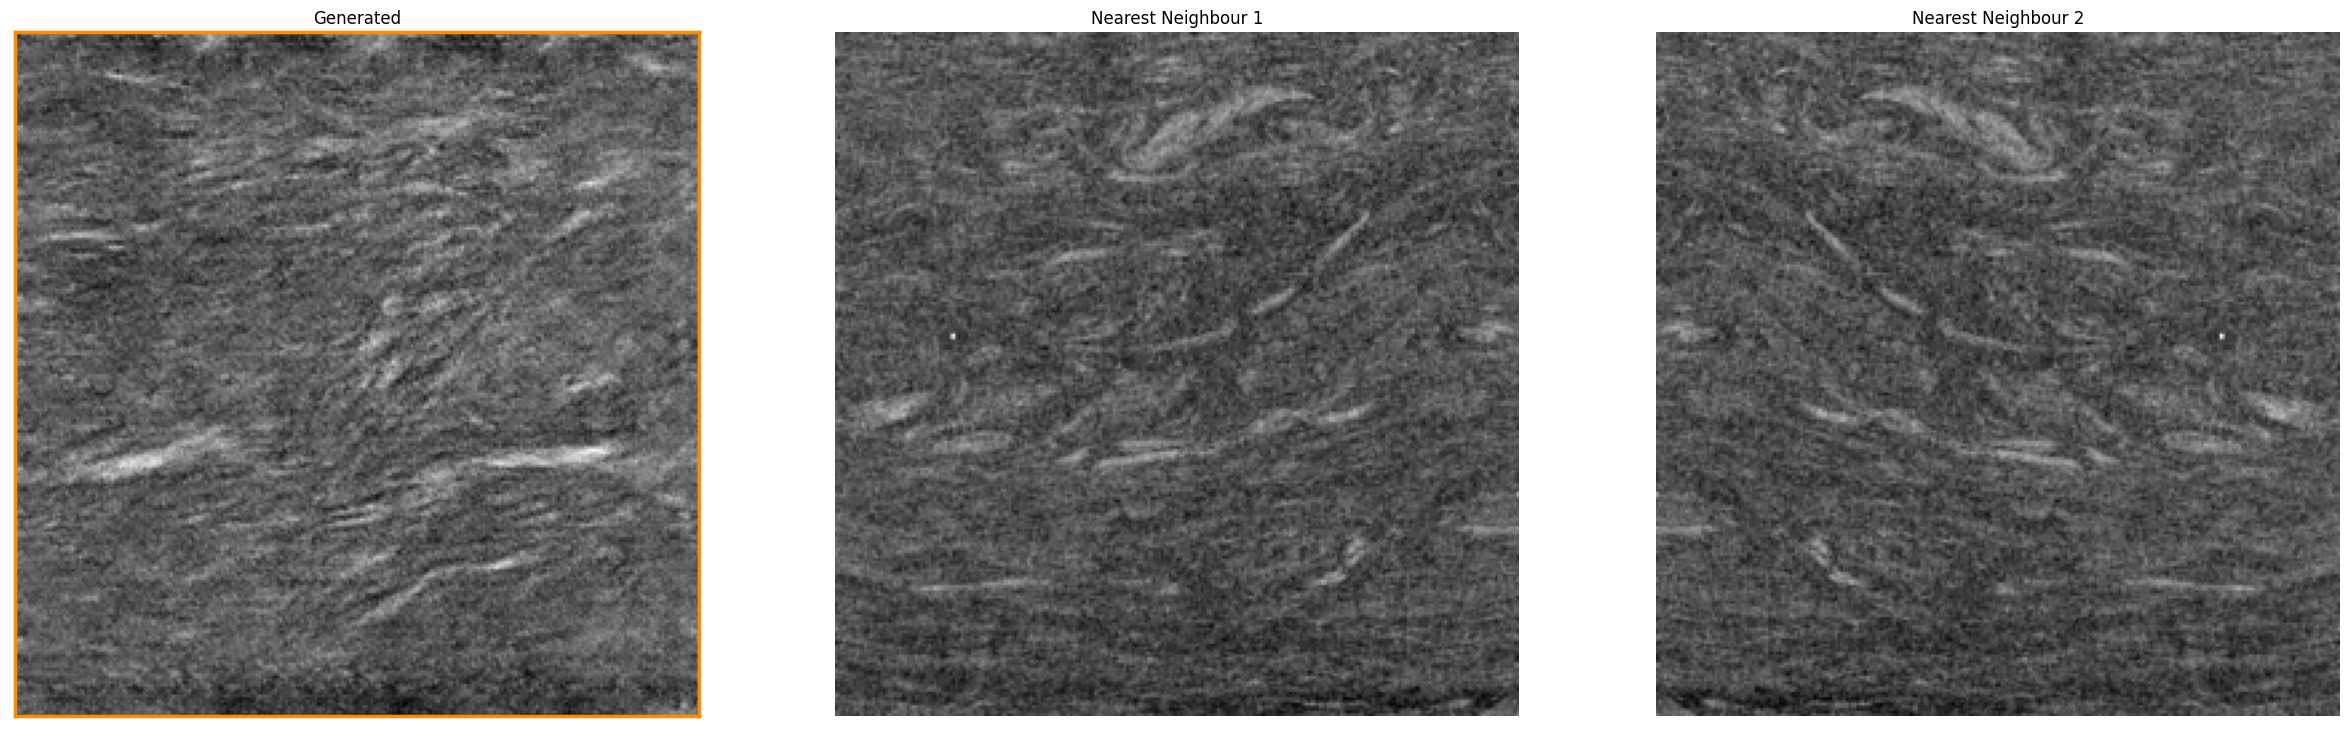

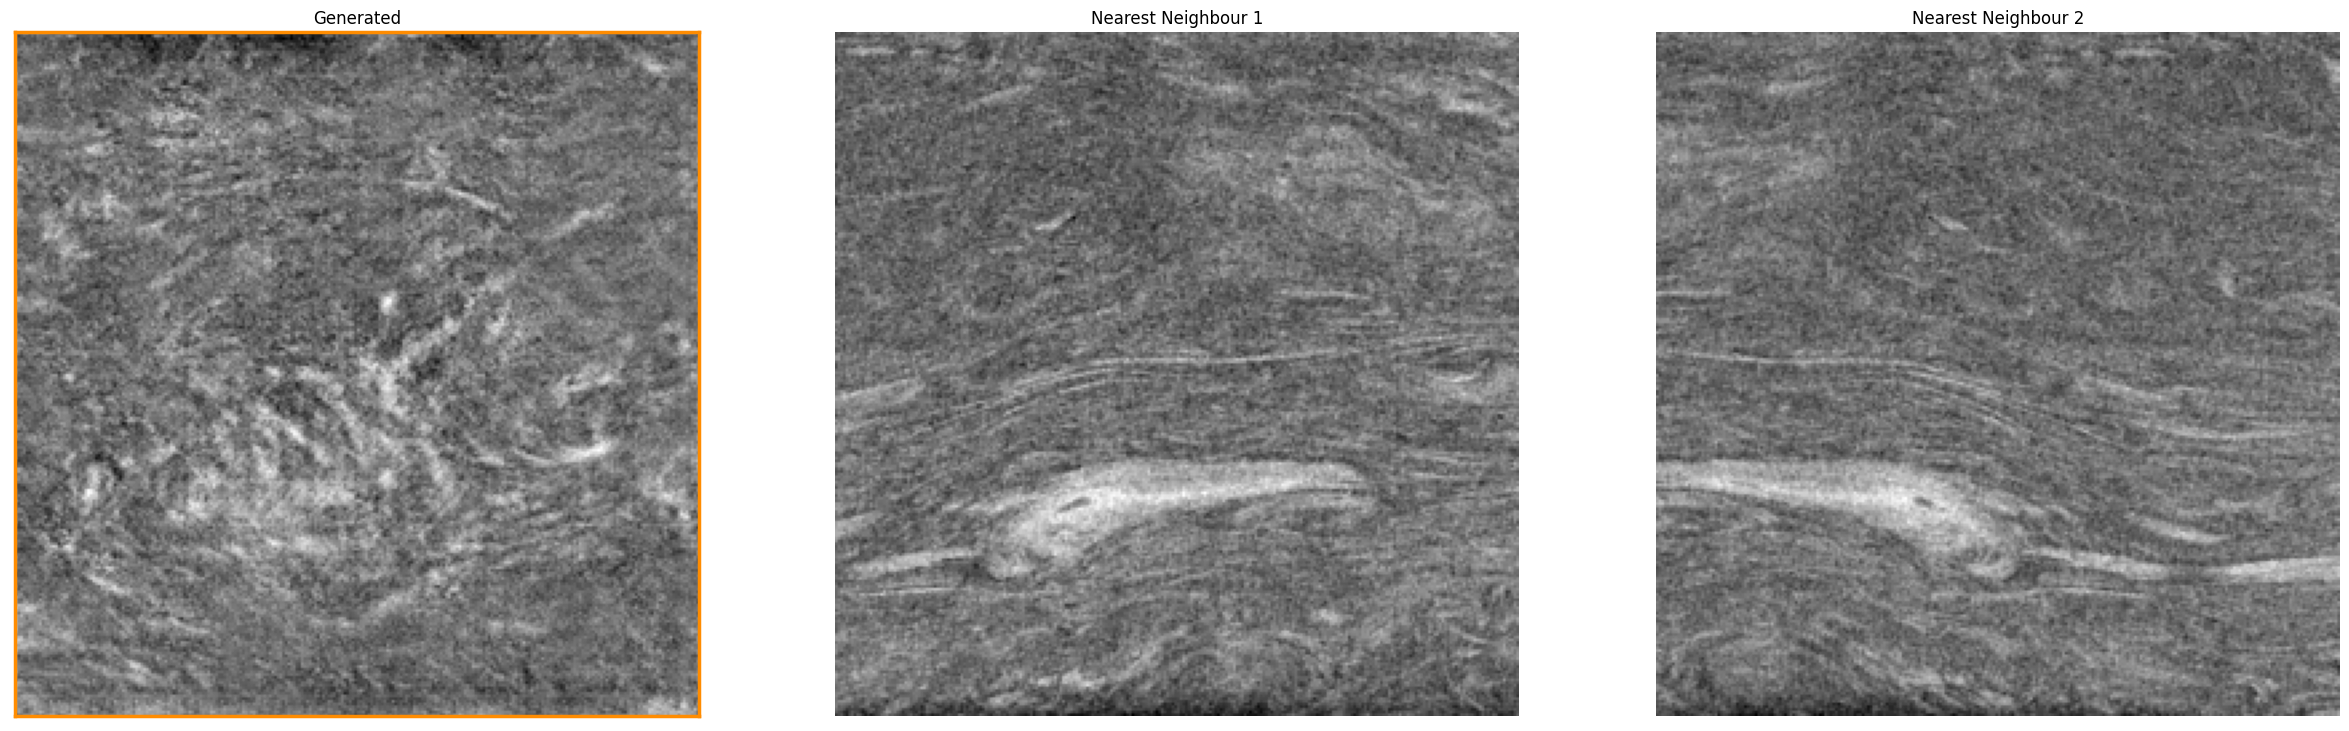

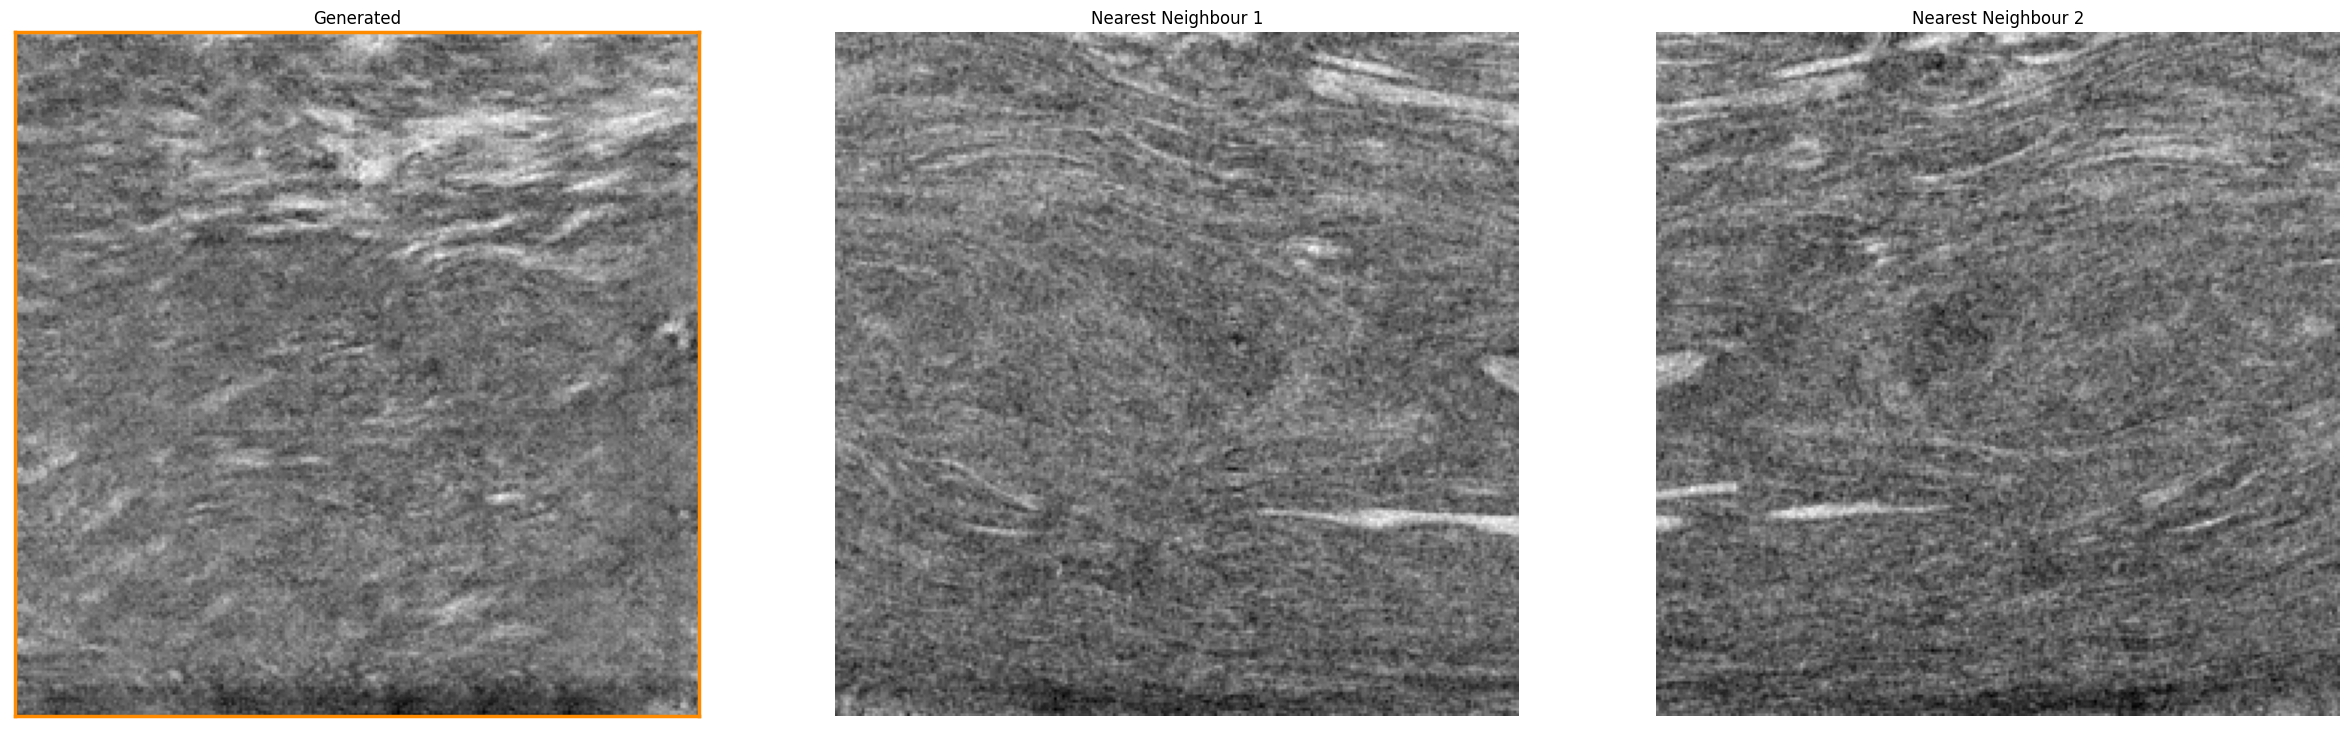

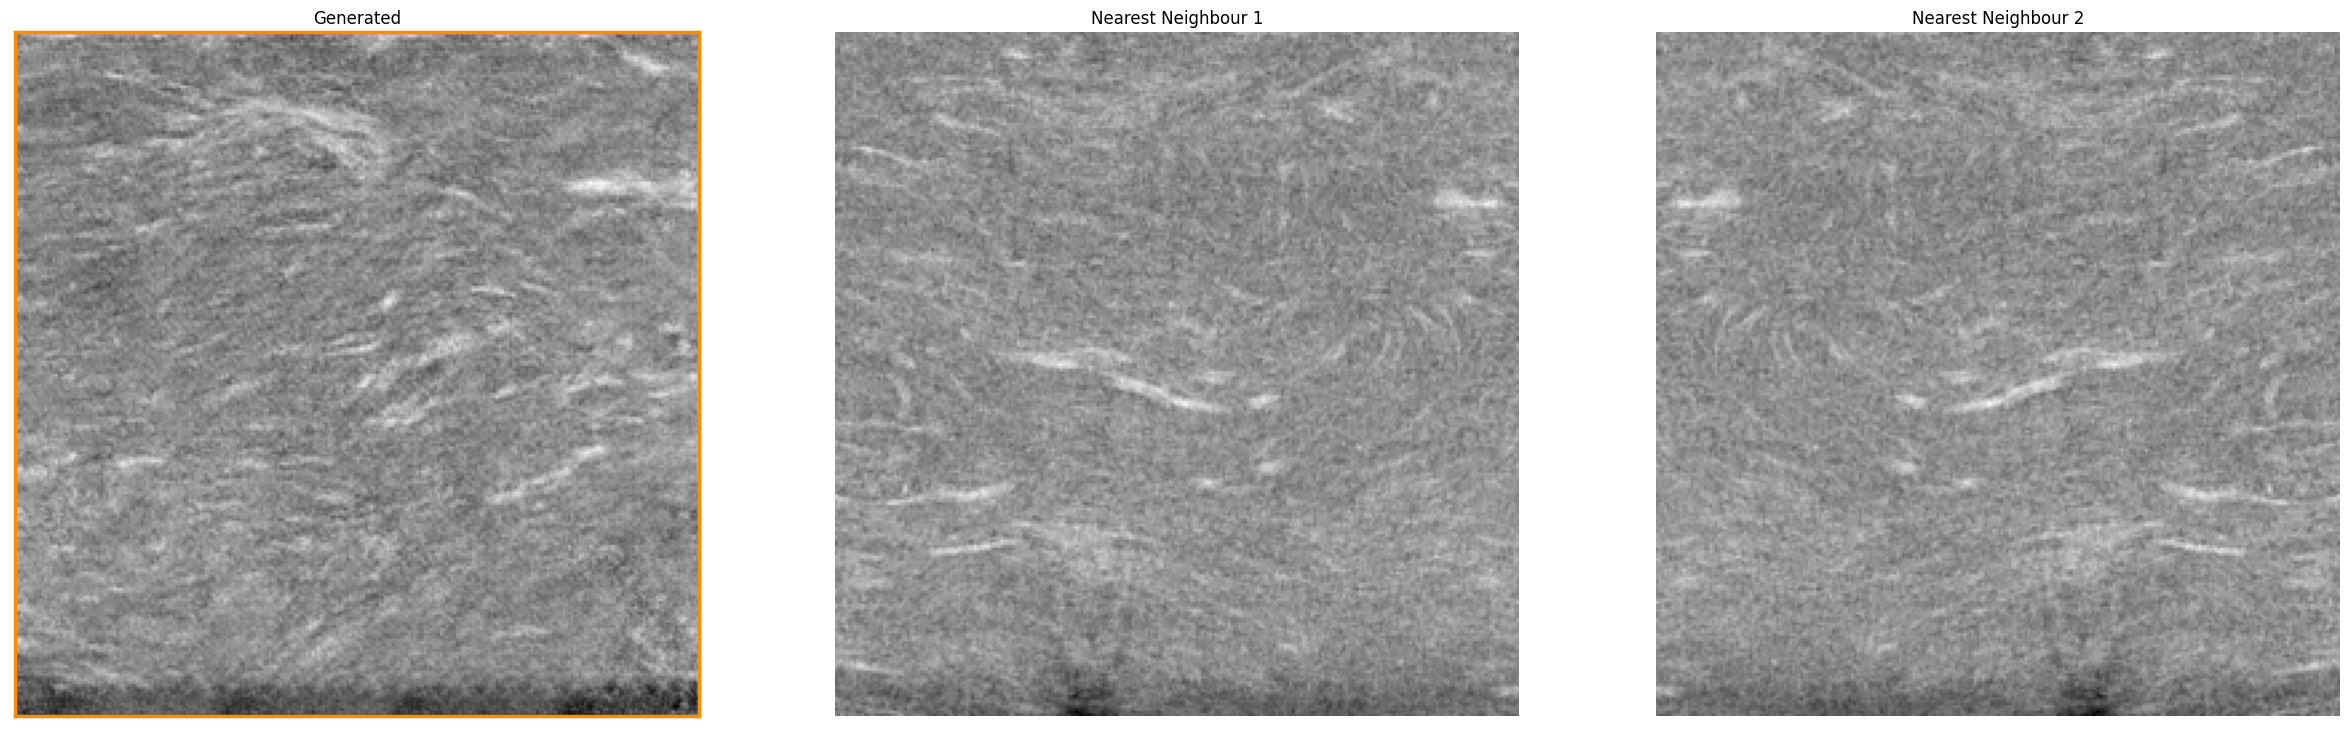

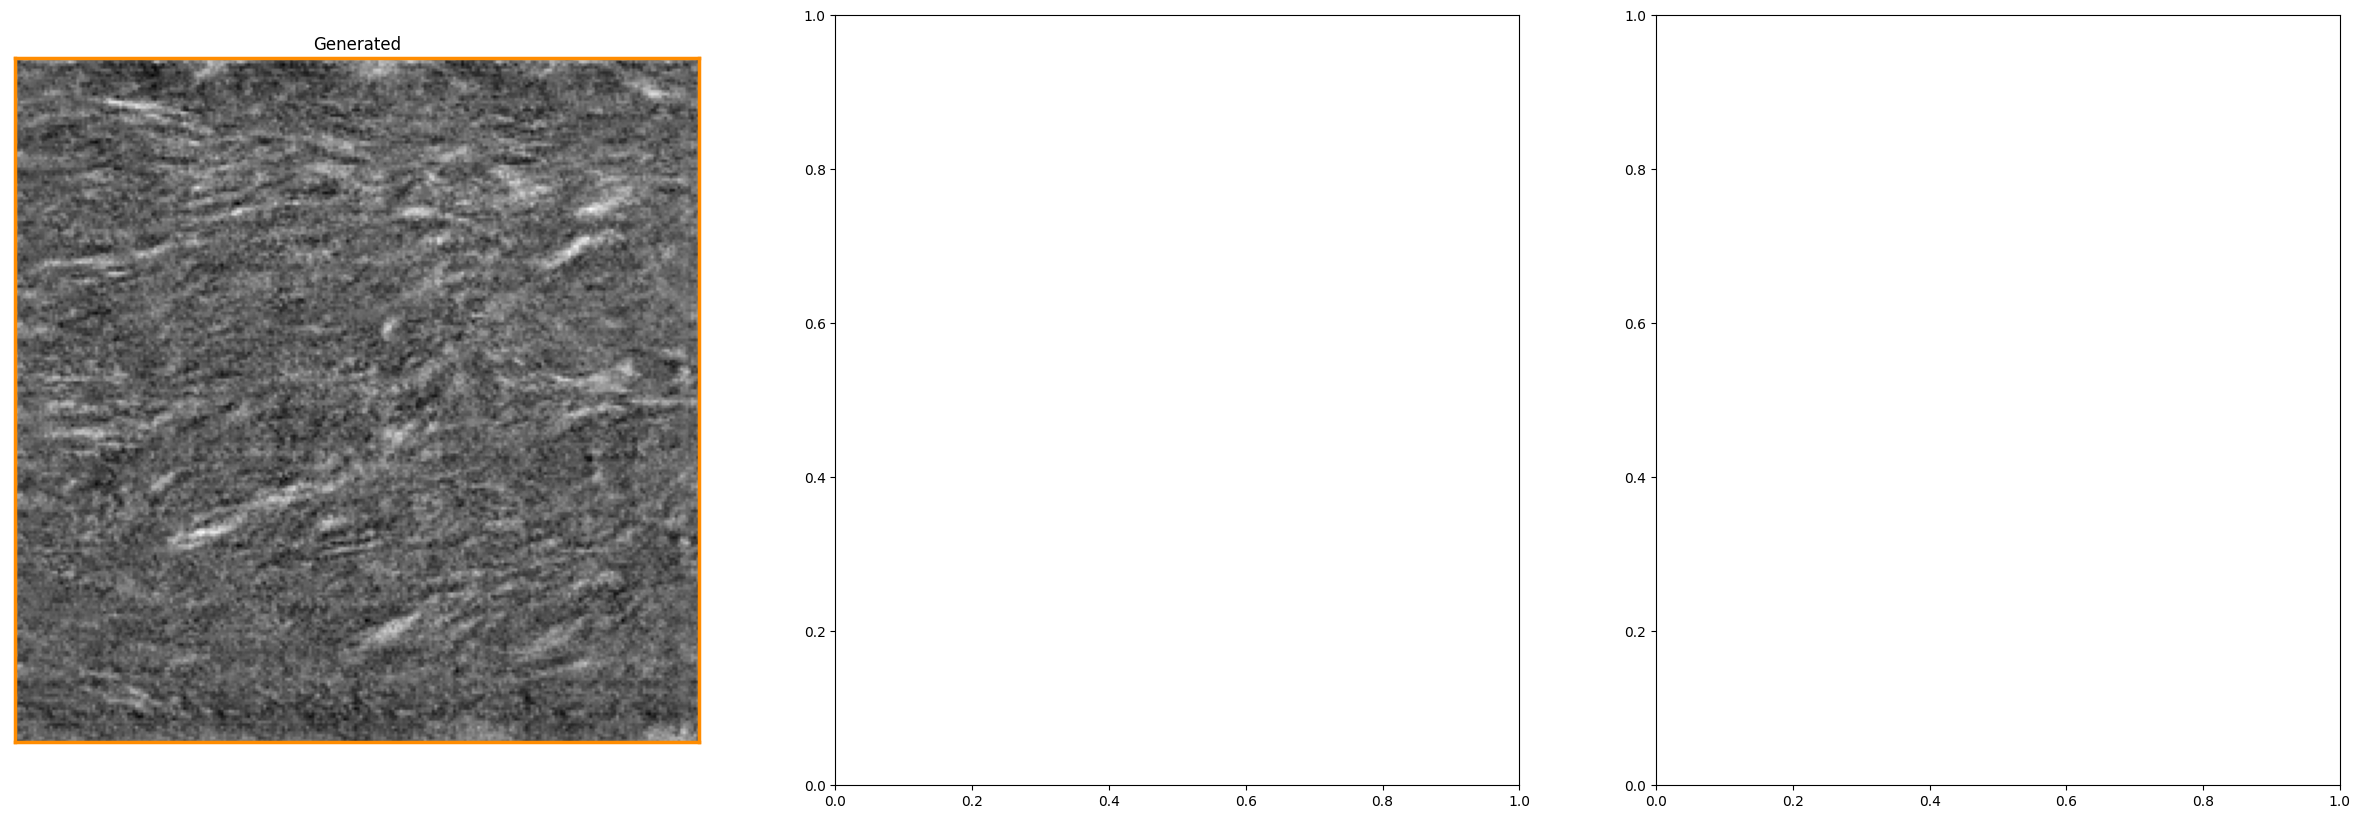

In [14]:
distance_knn = []

batch_size=128
size_input=256


def get_k_nearest_samples(fake_image, training_images, k=4):
    '''
    Searches for the k-nearest samples in the dataset of a given image based on the euclidean distance.
    '''
    def distance(tensor_a, tensor_b):
        '''
        Calculates the euklidean distance of two torch tensors of the same size.
        '''
        return torch.sqrt(((tensor_a - tensor_b) ** 2).sum())
    
    dist = [distance(fake_image, real_image) for real_image in training_images]
    
    distance_knn.append((np.argsort(dist)[:k])[0]) # save distance to nearest neighbor
    return np.argsort(dist)[:k], np.sort(dist)[:k] # argsort returns the indices that sort the array; index, distance value
    
    
# Get necessary images
train_imgs = train_set    # get array of real images without corresponding label
generated_samples = generated_samples


# index = get_k_nearest_samples(generated_samples[0], train_imgs, k=1)
# print(index)
#print(x)
#print(list)

'''
eukl_dist = [(get_k_nearest_samples(generated_samples[i], train_imgs, k=1)[1])[0] for i in tqdm(range(75))]
print(eukl_dist)

### Plot euklidean distance for all images samples in generated batch
fig, ax1 = plt.subplots(figsize=(30, 10))
ax1.plot(np.arange(1, 75+1, 1), eukl_dist, color="darkorange")        # use if statement to not show duplicates at each iteration
ax1.set_title('ED progression of a single image')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Euklidean Distance")

plt.axhline(y=np.mean(eukl_dist), color='black', linestyle='--', label= 'Mean euklidean distance: %.4f (Standard deviation: %.4f)' % (np.mean(eukl_dist), np.std(eukl_dist)))
ax1.legend(loc="upper right")
#ax1.set_xticks(np.arange(1, batch_size+1, 1.0))
#ax1.set_xlim(1, 24)
ax1.grid()
to_csv(path_output+'/'+name_output+'_NN_SSIM.csv', eukl_dist)
plt.savefig(path_output+'/'+name_output+'_nearest_Neighbour_ED_evolution.png', dpi=250)




eukl_dist = [(get_k_nearest_samples(generated_samples[i], train_imgs, k=1)[1])[0] for i in tqdm(range(batch_size))]
print(eukl_dist)

### Plot euklidean distance for all images samples in generated batch
fig, ax1 = plt.subplots(figsize=(30, 10))
ax1.plot(np.arange(1, batch_size+1, 1), np.sort(eukl_dist), color="darkorange")        # use if statement to not show duplicates at each iteration
ax1.set_title('Minimum euklidean distance of all images in one batch (sorted)')
ax1.set_xlabel("Image number")
ax1.set_ylabel("Euklidean Distance")

plt.axhline(y=np.mean(eukl_dist), color='black', linestyle='--', label= 'Mean euklidean distance: %.4f (Standard deviation: %.4f)' % (np.mean(eukl_dist), np.std(eukl_dist)))
ax1.legend(loc="upper right")
#ax1.set_xticks(np.arange(1, batch_size+1, 1.0))
#ax1.set_xlim(1, 24)
ax1.grid()
to_csv(path_output+'/'+name_output+'_NN_SSIM.csv', np.sort(eukl_dist))
plt.savefig(path_output+'/'+name_output+'_nearest_Neighbour_SSIM.png', dpi=250)

# print('==========================================================================================')
# print('Mean euklidean distance:', np.mean(eukl_dist))
# print('Standard deviation:', np.std(eukl_dist))
# print('==========================================================================================')

#ax1.legend(loc="upper right")
'''


k = 2               # number of nearest neighbours to be displayed
n = 6              # number of images
eukl_index = [(get_k_nearest_samples(generated_samples[i], train_imgs, k=k)[0]) for i in range(n)]
print(eukl_index)

print("---")
'''
#'''
### Plot nearest neighbours
for i in tqdm(range(75)):
    
    f, ax = plt.subplots(1,k+1, figsize=(30, 10))
    ax[0].imshow(generated_samples[i].reshape(size_input, size_input), cmap="gray")
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[0].set_title("Generated")
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[0].spines[axis].set_linewidth(2.5)  # change width
        ax[0].spines[axis].set_color('darkorange')    # change color
    
    for j in range(k):
        ax[j+1].imshow(train_imgs[(eukl_index[i])[j]].reshape(size_input, size_input), cmap="gray")  # display only 0,4,8 because otherwise the first images are the same, just augmented (flipped)
        ax[j+1].axis('off')
        ax[j+1].set_title(f"Nearest Neighbour {j+1}")
        # ax[2].imshow(samples[x[1]].reshape(size_input, size_input), cmap="gray")
        # ax[2].axis('off')
        # ax[2].set_title("Nearest Neighbour 2")
        # ax[3].imshow(samples[x[2]].reshape(size_input, size_input), cmap="gray")
        # ax[3].axis('off')
        # ax[3].set_title("Nearest Neighbour 3")
    plt.savefig(path_output+'/'+name_output+f'_nearest_neighbour_ED_{i}.png', dpi=250)
    plt.savefig(path_output+'/'+name_output+f'_nearest_neighbour_ED_{i}.eps', format='eps')

print('ED finished')
#'''

In [ ]:
print(distance_knn)

[8282, 9995, 10254, 24542, 25386, 12242, 9649, 9977, 8646, 8556, 2389, 2192, 9319, 8455, 2190, 8460, 9127, 2996, 9147, 8384, 8458, 10997, 8480, 8244, 10997, 10886, 2204, 11108, 3082, 2498, 2490, 10886, 10298, 11190, 12756, 11267, 10361, 11200, 9543, 9539, 9542, 27537, 9539, 3429, 27540, 25290, 25290, 9518, 12242, 9641, 9539, 9540, 9539, 1804, 9570, 9629, 12242, 12242, 9531, 12142, 12243, 9518, 12242, 12243, 9517, 9655, 12242, 11079, 12241, 2599, 12241, 12242, 12143, 9518, 12242]
